<div style="text-align: center;">
    <h3>Applied Data Science Project</h3>
    <h2><b>Patient Preference Studies Classification System</b><h2>
    <h1><b>Design & Test Soft Majority Vote Model Parameters</b></h1>
    <h5>Francesco Giuseppe Gillio</h5>
    <h5>César Augusto Seminario Yrigoyen</h5>
</div>

<div style="text-align: center;">
    <img src="https://upload.wikimedia.org/wikipedia/it/4/47/Logo_PoliTo_dal_2021_blu.png" width="250">
</div>

https://github.com/adsp-polito/2024-P8-PPS

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# *Drive* **Setup**

In [ ]:
import os
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Patient Preference Studies Binary Classifier
root = 'PPS-BC'

In [ ]:
path = os.path.join('/content/drive/MyDrive', root)
if not os.path.exists(path):
    os.makedirs(path)

In [ ]:
paths = {
    'input-data': f'{root}/input-data',
    'bert-embeddings': f'{root}/bert-embeddings',
    'notebook-results': f'{root}/notebook-results',
}

In [ ]:
for key, value in paths.items():
    path = os.path.join('/content/drive/MyDrive', value)
    if not os.path.exists(path):
        os.makedirs(path)

**Notebook Directory Structure**
```
/PPS-BC
├── /input-data
│   ├── logs.txt
│   ├── clean-articles-2023.csv
│   ├── raw-articles-2023.csv
│   └── /cv-splits
│       ├── /k-fold-2
│       │   ├── fold-1-test.csv
│       │   ├── fold-1-train.csv
│       │   └── ...
│       ├── /k-fold-3
│       │   └── ...
│       ├── /k-fold-5
│       │   └── ...
│       └── ...
├── /bert-embeddings
│   ├── logs.txt
│   ├── /bert-base-uncased
│   │   ├── abstract-text-classification-token.pkl
│   │   ├── abstract-text-hidden-states.pkl
│   │   └── ...
│   ├── /pubmedbert-base-embeddings
│   │   └── ...
│   ├── /S-PubMedBert-MS-MARCO
│   │   └── ...
│   └── ...
└── /notebook-results
    ├── ...
    └── /majority-vote-params
        └── ...
```

# *Classifier* **Models**

**Requirements**

In [ ]:
import numpy as np

In [ ]:
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier
from sklearn.neighbors import KNeighborsClassifier

**Positive Predictive Value Model**

**BERT-Base Model:** *BiomedNLP-BiomedBERT-base-uncased-abstract*

**T&A Link:** *vector-weighted-average-2080-hidden-states*

**Classifier Model:** *C-Support Vector Classifier* with {'kernel': rbf, 'C': 10.0, 'gamma': 'auto'}

**Scores:** **PPV = 0.957**, *TPR = 0.888*, *F2-PPS = 0.901*, *F1-PPS = 0.921*

In [ ]:
PPV = {}

In [ ]:
PPV['model'] = os.path.join(f"/content/drive/MyDrive/{paths['bert-embeddings']}", 'BiomedNLP-BiomedBERT-base-uncased-abstract')

In [ ]:
PPV['link'] = 'vector-weighted-average-2080-hidden-states.pkl'

In [ ]:
PPV['classifier'] = SVC(
    kernel="rbf",
    probability=True,
    class_weight="balanced",
    random_state=42,
    max_iter=1000,
    gamma='auto',
    C=1e1
)

**True Positive Rate Model**

**BERT-Base Model:** *pubmedbert-base-embeddings*

**T&A Link:** *vector-concatenation-classification-token*

**Classifier Model:** *k-Nearest Neighbors Classifier* with {'n_neighbors': 5, 'metric': 'euclidean'}

**Scores:** **TPR = 0.953**, *PPV = 0.724*, *F2-PPS = 0.897*, *F1-PPS = 0.823*

In [ ]:
TPR = {}

In [ ]:
TPR['model'] = os.path.join(f"/content/drive/MyDrive/{paths['bert-embeddings']}", 'pubmedbert-base-embeddings')

In [ ]:
TPR['link'] = 'vector-concatenation-classification-token.pkl'

In [ ]:
TPR['classifier'] = KNeighborsClassifier(
    n_neighbors=5,
    weights="distance",
    metric="euclidean"
)

**Soft Majority Vote Model Parameters:** *Threshold Values* and *Soft Majority Vote Weights*

In [ ]:
thresholds = np.round(
    np.arange(
        0.4 - 0.0125,
        0.5 + 0.0125,
        0.0125
    ), 4
)
weights = [
    (
        round(x, 4),
        round(1 - x, 4)
    )
    for x in np.arange(
        0.4 - 0.025,
        0.6 + 0.025,
        0.0125
    )
]

# **Design & Test** *Soft Majority Vote Model* **Parameters**

**Requirements**

In [ ]:
import os
import sys
import numpy as np
import pandas as pd

from typing import Dict, List, Tuple, Union, Any

In [ ]:
from itertools import product
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score,
    balanced_accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    matthews_corrcoef,
    fbeta_score,
    roc_auc_score,
    average_precision_score,
    log_loss,
    brier_score_loss
)

In [ ]:
np.random.seed(42)

In [ ]:
device = 'cpu'
device

'cpu'

In [ ]:
input = f"/content/drive/MyDrive/{paths['input-data']}"

In [ ]:
output = os.path.join(f"/content/drive/MyDrive/{paths['notebook-results']}", 'majority-vote-params')
if not os.path.exists(output):
    os.makedirs(output)

In [ ]:
with open(os.path.join(output, 'logs.txt'), 'w') as file:
    pass

**Evaluation Metrics**

In [ ]:
def compute(
    y_true: np.ndarray,
    y_pred: np.ndarray,
    y_prob: np.ndarray
) -> Dict[str, float]:
    """
    compute classification metrics for predictions

    args:
        y_true (np.ndarray): ground truth labels for the test set
        y_pred (np.ndarray): predictions for the test set
        y_prob (np.ndarray): probabilities for the positive class

    returns:
        Dict[str, float]: a dictionary with classification metrics
    """
    metrics = {
        'F2-PPS': fbeta_score(
            y_true, y_pred, beta=2, pos_label=1
        ),  # F2-Score (Class 1)
        'F1-PPS': f1_score(
            y_true, y_pred, pos_label=1
        ),  # F1-Score (Class 1)

        'TPR': recall_score(
            y_true, y_pred, pos_label=1
        ),  # True Positive Rate (TPR)
        'FNR': 1 - recall_score(
            y_true, y_pred, pos_label=1
        ),  # False Negative Rate (FNR)
        'PPV': precision_score(
            y_true, y_pred, pos_label=1
        ),  # Positive Predictive Value (PPV)
        'FDR': 1 - precision_score(
            y_true, y_pred, pos_label=1
        ),  # False Discovery Rate (FDR)

        'AUC-PR': average_precision_score(
            y_true, y_prob
        ),  # Area Under Precision-Recall Curve (AUC-PR)
        'BA': balanced_accuracy_score(
            y_true, y_pred
        ),  # Balanced Accuracy (BA)
        'AUC-ROC': roc_auc_score(
            y_true, y_prob
        ),  # Area Under ROC Curve (AUC-ROC)

        'G-Mean': np.sqrt(
            recall_score(
                y_true, y_pred, pos_label=1
            ) *
            recall_score(
                y_true, y_pred, pos_label=0
            )
        ),  # Geometric Mean (G-Mean)
        'MCC': matthews_corrcoef(
            y_true, y_pred
        ),  # Matthews Correlation Coefficient (MCC)

        'Log-Loss': log_loss(
            y_true, y_prob
        ),  # Log-Loss
        'BS': brier_score_loss(
            y_true, y_prob
        ),  # Brier Score

        'TNR': recall_score(
            y_true, y_pred, pos_label=0
        ),  # True Negative Rate (TNR)
        'FPR': 1 - recall_score(
            y_true, y_pred, pos_label=0
        ),  # False Positive Rate (FPR)
        'NPV': precision_score(
            y_true, y_pred, pos_label=0
        ),  # Negative Predictive Value (NPV)
        'FOR': 1 - precision_score(
            y_true, y_pred, pos_label=0
        ),  # False Omission Rate (FOR)

        'Accuracy': accuracy_score(
            y_true, y_pred
        ),  # Accuracy
        'Weighted F1-Score': f1_score(
            y_true, y_pred, average='weighted'
        ),  # Weighted F1-Score
        'Weighted Precision': precision_score(
            y_true, y_pred, average='weighted'
        ),  # Weighted Precision
        'Weighted Recall': recall_score(
            y_true, y_pred, average='weighted'
        ),  # Weighted Recall
        'Macro F1-Score': f1_score(
            y_true, y_pred, average='macro'
        ),  # Macro F1-Score
        'Macro Precision': precision_score(
            y_true, y_pred, average='macro'
        ),  # Macro Precision
        'Macro Recall': recall_score(
            y_true, y_pred, average='macro'
        )   # Macro Recall
    }
    return metrics

*Evaluation Metrics Sorting Criteria*

In [ ]:
order = [
    'F2-PPS', # F2-Score (Class 1 - Patient Preference Studies)
    'F1-PPS', # F1-Score (Class 1 - Patient Preference Studies)
    'TPR',    # True Positive Rate
    'PPV',    # Positive Predictive Value
    'AUC-PR', # Area Under Precision-Recall Curve
    'BA',     # Balanced Accuracy
    'AUC-ROC' # Area Under ROC Curve
]

**Binary Classification**

In [ ]:
def evaluate(
    TPR: Dict[str, Union[str, Any]],
    PPV: Dict[str, Union[str, Any]],
    case: str,
    input: str,
    output: str,
    order: List[str],
    weights: List[Tuple[float, float]],
    thresholds: List[float]
) -> pd.DataFrame:
    """
    evaluate soft majority vote model parameters for class prediction

    args:
        TPR (Dict[str, Union[str, Any]]): dictionary with model, link and classifier instance
                                          for high recall model
        PPV (Dict[str, Union[str, Any]]): dictionary with model, link and classifier instance
                                          for high precision model
        case (str): cross-validation case identifier (e.g. 'k-fold-2' or 'k-fold-3')
        input (str): path to the input folder with data and splits
        output (str): path to output folder to store logs
        order (List[str]): evaluation metrics sorting criteria
        weights (List[Tuple[float, float]]): list of weight pairs for soft majority vote
                                             (vote weight for high recall model,
                                              vote weight for high precision model)
        thresholds (List[float]): threshold values ​​for class prediction

    returns:
        pd.DataFrame: DataFrame with evaluation results
    """

    def add(
        by: str,
        to: str
    ) -> pd.DataFrame:
        """
        add an embeddings column to the input split file

        args:
            by (str): path to the .pkl file with embeddings
            to (str): path to the .csv split file
        """
        dataset = pd.read_pickle(by)
        frame = pd.read_csv(to)
        embeddings = [
            column for column in dataset.columns
            if column not in ['title', 'abstract', 'label']
        ]
        data = frame.merge(
            dataset[['title', 'abstract', 'label'] + embeddings],
            on=['title', 'abstract', 'label'],
            how='left'
        )
        return data

    def collect(
        dir: str
    ) -> List[Tuple[str, str]]:
        """
        collect train and test file pairs from the directory

        args:
            dir (str): path to the directory with train/test files

        returns:
            List[Tuple[str, str]]: list of (train file, test file) tuples
        """
        files = {'train': [], 'test': []}
        for idx, _, walk in os.walk(dir):
            for file in walk:
                if file.endswith('.csv'):
                    if 'train' in file:
                        files['train'].append(
                            os.path.join(idx, file)
                        )
                    elif 'test' in file:
                        files['test'].append(
                            os.path.join(idx, file)
                        )
        files['train'].sort()
        files['test'].sort()
        return list(zip(files['train'], files['test']))

    log = f'\n{case}\n'
    with open(os.path.join(output, 'logs.txt'), 'a') as file:
        file.write(log + '\n')
    combinations = list(
        product(weights, thresholds)
    )
    steps = len(combinations) * len(
        collect(
            os.path.join(input, 'cv-splits', case)
        )
    )
    progress = 0
    results = list()
    print(f"processing {case}...")
    for weight, threshold in combinations:
        params = f'{weight} & {threshold}'
        log = f'-' * 50 + '\n' + f'Soft Majority Vote Parameters: {params}\n' + f'-' * 50 + '\n'
        with open(os.path.join(output, 'logs.txt'), 'a') as file:
            file.write(log + '\n')
        averages = {}
        route = os.path.join(input, 'cv-splits', case)
        for files in collect(route):
            progress += 1
            percentage = (progress / steps) * 100
            sys.stdout.write(f"\revaluating soft majority vote model parameters... {percentage:.2f}%")
            sys.stdout.flush()
            log = f'classifier execution on:\n- train file: {os.path.basename(files[0])}\n- test file: {os.path.basename(files[1])}'
            with open(os.path.join(output, 'logs.txt'), 'a') as file:
                file.write(log + '\n')
            # train and test: TPR (high recall) model
            model = TPR
            embeddings = os.path.join(model['model'], model['link'])
            data_train = add(
                by=embeddings,
                to=files[0]
            )
            data_test = add(
                by=embeddings,
                to=files[1]
            )
            # model independent
            y_train = data_train['label']
            y_test = np.array(data_test['label'].tolist())
            # skip non-embedding columns
            column = [
                column for column in data_train.columns
                if column not in ['label', 'title', 'abstract']
            ][0]
            if not isinstance(data_train[column].values[0], np.ndarray):
                # debug
                print(f'WARNING: {column} not of type np.ndarray')
                continue
            # model-dependent values ​​(TPR-specific)
            x_train = np.array(data_train[column].tolist())
            x_test = np.array(data_test[column].tolist())
            classifier = model['classifier']
            pipeline = Pipeline([
                ('scaler', StandardScaler()),
                ('classifier', classifier)
            ])
            pipeline.fit(x_train, y_train)
            alpha = pipeline.predict_proba(x_test)
            # train and test: PPV (high precision) model
            model = PPV
            embeddings = os.path.join(model['model'], model['link'])
            data_train = add(
                by=embeddings,
                to=files[0]
            )
            data_test = add(
                by=embeddings,
                to=files[1]
            )
            # model independent
            y_train = data_train['label']
            y_test = np.array(data_test['label'].tolist())
            # skip non-embedding columns
            column = [
                column for column in data_train.columns
                if column not in ['label', 'title', 'abstract']
            ][0]
            if not isinstance(data_train[column].values[0], np.ndarray):
                # debug
                print(f'WARNING: {column} not of type np.ndarray')
                continue
            # model-dependent values ​​(PPV-specific)
            x_train = np.array(data_train[column].tolist())
            x_test = np.array(data_test[column].tolist())
            classifier = model['classifier']
            pipeline = Pipeline([
                ('scaler', StandardScaler()),
                ('classifier', classifier)
            ])
            pipeline.fit(x_train, y_train)
            beta = pipeline.predict_proba(x_test)
            # soft majority vote for class prediction
            a, b = weight
            probs = (alpha * a) + (beta * b)
            preds = (probs[:, 1] >= threshold).astype(int)
            metrics = compute(
                y_true=y_test,
                y_pred=preds,
                y_prob=probs[:, 1]
            )
            for metric in ['F2-PPS', 'F1-PPS', 'TPR', 'PPV']:
                log = f"{metric}: {metrics[metric]}"
                with open(os.path.join(output, 'logs.txt'), 'a') as file:
                    file.write(log + '\n')
            if str(params) not in averages:
                averages[str(params)] = {
                    key: [] for key in metrics
                }
            for key, value in metrics.items():
                averages[str(params)][key].append(value)
        for param, scores in averages.items():
            mean = {
                key: np.mean(values)
                for key, values in scores.items()
            }
            results.append({
                'Soft Majority Vote Parameters': param,
                **mean
            })
            for idx, metric in enumerate(['F2-PPS', 'F1-PPS', 'TPR', 'PPV']):
                log = ('\n' if idx == 0 else '') + metric + ': ' + str(mean[metric])
                with open(os.path.join(output, 'logs.txt'), 'a') as file:
                    file.write(log + '\n')
    print()
    data = pd.DataFrame(results)
    data = data.sort_values(
        by=order,
        ascending=[False] * len(order)
    )
    return data

*Fibonacci Sequence:* **[2, 3, 5, 8, 13, 21]**

Splits: **[2 + 3 + 21]** & **[5 + 8 + 13]**

*Split into 2 blocks of 26 iterations for* **VxW** *configurations, with* **V = 10** *threshold values and* **W = 20** *majority vote weights*

*Computational effort per split:* **VxWx26 = 10x20x26=5.200** *iterations on* **1.215** *data points each*

In [ ]:
for seed in [2, 3, 21]:
    results = evaluate(
        TPR = TPR,
        PPV = PPV,
        case = f'k-fold-{seed}',
        input = input,
        output = output,
        order = order,
        weights = weights,
        thresholds = thresholds
    )
    results.to_csv(os.path.join(output, f'k-fold-{seed}-results.csv'), index=False)

processing k-fold-2...
evaluating soft majority vote model parameters... 100.00%
processing k-fold-3...
evaluating soft majority vote model parameters... 100.00%
processing k-fold-21...
evaluating soft majority vote model parameters... 100.00%


In [ ]:
for seed in [5, 8, 13]:
    results = evaluate(
        TPR = TPR,
        PPV = PPV,
        case = f'k-fold-{seed}',
        input = input,
        output = output,
        order = order,
        weights = weights,
        thresholds = thresholds
    )
    results.to_csv(os.path.join(output, f'k-fold-{seed}-results.csv'), index=False)

processing k-fold-5...
evaluating soft majority vote model parameters... 100.00%
processing k-fold-8...
evaluating soft majority vote model parameters... 100.00%
processing k-fold-13...
evaluating soft majority vote model parameters... 100.00%


# *Statistical* **Data Analysis**

**Requirements**

In [ ]:
import os
import glob
import numpy as np
import pandas as pd
import scipy.stats as stats

import seaborn as sns
import matplotlib.pyplot as plt

from typing import List, Dict

In [ ]:
np.random.seed(42)

In [ ]:
device = 'cpu'
device

'cpu'

In [ ]:
output = os.path.join(f"/content/drive/MyDrive/{paths['notebook-results']}", 'majority-vote-params')

*Evaluation Metrics Sorting Criteria*

In [ ]:
order = [
    'F2-PPS', # F2-Score (Class 1 - Patient Preference Studies)
    'F1-PPS', # F1-Score (Class 1 - Patient Preference Studies)
    'TPR',    # True Positive Rate
    'PPV',    # Positive Predictive Value
    'AUC-PR', # Area Under Precision-Recall Curve
    'BA',     # Balanced Accuracy
    'AUC-ROC' # Area Under ROC Curve
]

In [ ]:
def combine(
    dir: str,
    main: List[str],
    order: List[str]
) -> pd.DataFrame:
    """
    combine multiple .csv files into a single DataFrame

    args:
        dir (str): path to the folder with .csv files
        main (List[str]): main group-by columns
        order (List[str]): evaluation metrics sorting criteria

    returns:
        pd.DataFrame: DataFrame with scores
    """
    files = glob.glob(os.path.join(dir, "*.csv"))
    data = list()
    for file in files:
        frame = pd.read_csv(file)
        data.append(frame)
    concat = pd.concat(data)
    data = (
        concat.groupby(main)
        .agg(
            ['mean', 'std']
        )
        .reset_index()
    )
    data.columns = [
        '-'.join(column).strip('-') for column in data.columns
        if column not in main
    ]
    for column in data.columns:
        if column.endswith('-mean'):
            base = column.rsplit('-', 1)[0]
            deviation = f'{base}-std'
            if deviation in data.columns:
                # compute confidence interval
                N = len(concat.groupby(main))
                sem = data[deviation] / np.sqrt(N)
                deg = N - 1
                # 99% confidence level
                critical = stats.t.ppf(0.995, deg)
                lower = data[column] - critical * sem
                upper = data[column] + critical * sem
                data[f'{base}-ci'] = (
                    data[column].round(3).astype(str) + " ± " +
                    ((upper - lower) / 2).round(3).astype(str)
                )
    data = data.sort_values(
        by=[f"{metric}-mean" for metric in order],
        ascending=[False] * len(order)
    )
    columns = [
        column for column in data.columns
        if column.endswith('-ci')
    ]
    data = data[main + columns]
    data.columns = [
        column.replace('-ci', '') for column in data.columns
    ]
    return data

In [ ]:
def get(
    data: pd.DataFrame,
    case: str,
    order: List[str]
) -> pd.DataFrame:
    """
    get a dataframe by group-by on input column

    args:
        data (pd.DataFrame): DataFrame with evaluation results
        case (str): group-by column to plot (e.g., 'BERT-Base Model')
        order (List[str]): evaluation metrics sorting criteria

    returns:
        pd.DataFrame: DataFrame with scores
    """
    data = data[[case] + order].copy()
    for metric in order:
        data[metric] = data[metric].str.extract(r'(\d+\.\d+)').astype(float)
    res = (
        data.groupby(case)
        .agg(
            ['mean', 'std']
        )
        .reset_index()
    )
    res.columns = [
        '-'.join(column).strip('-') for column in res.columns
        if column not in [case]
    ]
    for column in res.columns:
        if column.endswith('-mean'):
            base = column.rsplit('-', 1)[0]
            deviation = f'{base}-std'
            if deviation in res.columns:
                # compute confidence interval
                N = len(data.groupby([case]))
                sem = res[deviation] / np.sqrt(N)
                deg = N - 1
                # 99% confidence level
                critical = stats.t.ppf(0.995, deg)
                lower = res[column] - critical * sem
                upper = res[column] + critical * sem
                res[f'{base}-ci'] = (
                    res[column].round(3).astype(str) + " ± " +
                    ((upper - lower) / 2).round(3).astype(str)
                )
    res = res.sort_values(
        by=[f"{metric}-mean" for metric in order],
        ascending=[False] * len(order)
    )
    columns = [
        column for column in res.columns
        if column.endswith('-ci')
    ]
    res = res[[case] + columns]
    res.columns = [
        column.replace('-ci', '') for column in res.columns
    ]
    return res

In [ ]:
def plot(
    data: pd.DataFrame,
    column: str,
    output: str,
    order: List[str]
) -> None:
    """
    plot performance metrics with confidence intervals

    args:
        data (pd.DataFrame): DataFrame with evaluation results
        column (str): group-by column to plot (e.g., 'BERT-Base Model')
        output (str): path to output folder to store plot
        order (List[str]): evaluation metrics sorting criteria
    """
    data['true-positive-rate'] = data['TPR'].str.split(' ± ').apply(lambda x: float(x[0]) - float(x[1]))
    data['positive-predictive-value'] = data['PPV'].str.split(' ± ').apply(lambda x: float(x[0]) - float(x[1]))
    data = data[(data['true-positive-rate'] > 0.945) & (data['positive-predictive-value'] > 0.845)]
    data = data.head(20)
    chart = list()
    for metric in order:
        if metric in data.columns:
            for _, row in data.iterrows():
                ci = row[metric].split(' ± ')
                mean = float(ci[0])
                error = float(ci[1])
                chart.append({
                    column: row[column],
                    'Metric': metric,
                    'Mean': mean,
                    'Error': error
                })
    chart = pd.DataFrame(chart)
    chart[column] = chart[column].astype(str)
    plt.figure(figsize=(16, 9))
    position = -0.75
    ax = sns.barplot(
        chart,
        x=column,
        y='Mean',
        hue='Metric',
        ci=None,
        palette='crest'
    )
    for bar, (_, row) in zip(ax.patches, chart.iterrows()):
        center = bar.get_x() + bar.get_width() / 2
        lower = row['Mean'] - row['Error']
        upper = row['Mean'] + row['Error']
        plt.errorbar(
            x=center,
            y=row['Mean'],
            yerr=row['Error'],
            fmt='none',
            color='black',
            linestyle='-',
            linewidth=0.5
        )
    for idx, metric in enumerate(chart['Metric'].unique()):
        columns = chart[chart['Metric'] == metric]
        row = columns.loc[columns['Mean'].idxmax()]
        value = row['Mean']
        center = (
            ax.patches[
                chart.index.get_loc(row.name)
            ].get_x() +
            ax.patches[
                chart.index.get_loc(row.name)
            ].get_width() / 2
        )
        if metric in ['F2-PPS', 'F1-PPS', 'TPR', 'PPV']:
            ax.plot(
                [center, position],
                [value, value],
                color='black',
                linestyle='--',
                linewidth=0.5
            )
            ax.text(
                x=position,
                y=value,
                s=f'{value:.3f}',
                ha='right',
                va='center',
                fontsize=10
            )
    plt.title(
        f'{column} Performance Distributions',
        fontsize=15
    )
    plt.xlabel(
        column,
        fontsize=10
    )
    plt.ylabel(
        'Metric Value',
        fontsize=10
    )
    plt.legend(
        title=f'Metric',
        bbox_to_anchor=(1.05, 1),
        loc='upper left'
    )
    ax.set_xticklabels(
        ax.get_xticklabels(),
        rotation=45,
        ha="right",
        rotation_mode='anchor'
    )
    plt.ylim(
        bottom=0.80
    )
    plt.tight_layout()
    plt.savefig(
        f'{output}/{column.lower().replace(" ", "-")}-performance-plot.png',
        dpi=300,
        bbox_inches='tight'
    )
    plt.show()

*What to* **Move Forward**

In [ ]:
def select(
    dir: str,
    title: str,
    column: str,
    output: str,
    main: List[str],
    order: List[str],
    model: Dict[str, str] = None
) -> pd.DataFrame:
    """
    what to move forward

    args:
        dir (str): path to the folder with .csv file
        title (str): plot title
        column (str): group-by column to plot (e.g., 'BERT-Base Model')
        output (str): path to output folder to store plot
        main (List[str]): main group-by columns
        order (List[str]): evaluation metrics sorting criteria
        model (Dict[str, str], optional): dictionary with {'BERT-Base Model': 'bert-base model'} to filter

    returns:
        pd.DataFrame: DataFrame with scores
    """
    data = pd.read_csv(dir)
    data['true-positive-rate'] = data['TPR'].str.split(' ± ').apply(lambda x: float(x[0]) - float(x[1]))
    data['positive-predictive-value'] = data['PPV'].str.split(' ± ').apply(lambda x: float(x[0]) - float(x[1]))
    data = data[(data['true-positive-rate'] > 0.945) & (data['positive-predictive-value'] > 0.845)]
    data = data.head(20)
    data = data[main + order]
    if model:
        key, value = next(iter(model.items()))
        data = data[data[key] == value]
    def lower(value):
        base, error = map(float, value.split(' ± '))
        return base - error
    for metric in order:
        data[metric] = data[metric].apply(lower)
    data = data.sort_values(
        by=order,
        ascending=[False] * len(order)
    )
    data.to_csv(os.path.join(output, f'{title.lower().replace(" ", "-")}-ranks.csv'), encoding='utf-8', index=False)
    chart = []
    for metric in order:
        if metric in data.columns:
            for _, row in data.iterrows():
                mean = float(row[metric])
                chart.append({
                    column: row[column],
                    'Metric': metric,
                    'Mean': mean
                })
    chart = pd.DataFrame(chart)
    chart[column] = chart[column].astype(str)
    plt.figure(figsize=(16, 9))
    position = -0.75
    ax = sns.barplot(
        chart,
        x=column,
        y='Mean',
        hue='Metric',
        palette='crest'
    )
    for idx, metric in enumerate(chart['Metric'].unique()):
        columns = chart[chart['Metric'] == metric]
        row = columns.loc[columns['Mean'].idxmax()]
        value = row['Mean']
        center = (
            ax.patches[
                chart.index.get_loc(row.name)
            ].get_x() +
            ax.patches[
                chart.index.get_loc(row.name)
            ].get_width() / 2
        )
        if metric in ['F2-PPS', 'F1-PPS', 'TPR', 'PPV']:
            ax.plot(
                [center, position],
                [value, value],
                color='black',
                linestyle='--',
                linewidth=0.5
            )
            ax.text(
                x=position,
                y=value,
                s=f'{value:.3f}',
                ha='right',
                va='center',
                fontsize=10
            )
    plt.title(
        f'{title} Performance Distributions',
        fontsize=15
    )
    plt.xlabel(
        column,
        fontsize=10
    )
    plt.ylabel(
        'Metric Value',
        fontsize=10
    )
    plt.legend(
        title=f'Metric',
        bbox_to_anchor=(1.05, 1),
        loc='upper left'
    )
    ax.set_xticklabels(
        ax.get_xticklabels(),
        rotation=45,
        ha="right",
        rotation_mode='anchor'
    )
    plt.ylim(
        bottom=0.80
    )
    plt.tight_layout()
    plt.savefig(
        f'{output}/{title.lower().replace(" ", "-")}-performance-plot.png',
        dpi=300,
        bbox_inches='tight'
    )
    plt.show()
    return data

**Global** *Statistical Data Analysis*

In [ ]:
results = combine(
    dir = output,
    main = ['Soft Majority Vote Parameters'],
    order = order
)
results.head()

,Soft Majority Vote Parameters,F2-PPS,F1-PPS,TPR,FNR,PPV,FDR,AUC-PR,BA,AUC-ROC,...,FPR,NPV,FOR,Accuracy,Weighted F1-Score,Weighted Precision,Weighted Recall,Macro F1-Score,Macro Precision,Macro Recall
70,"(0.4625, 0.5375) & 0.3875",0.927 ± 0.001,0.895 ± 0.002,0.95 ± 0.0,0.05 ± 0.0,0.848 ± 0.003,0.152 ± 0.003,0.967 ± 0.0,0.955 ± 0.001,0.987 ± 0.0,...,0.04 ± 0.001,0.988 ± 0.0,0.012 ± 0.0,0.958 ± 0.001,0.959 ± 0.001,0.962 ± 0.001,0.958 ± 0.001,0.934 ± 0.001,0.918 ± 0.002,0.955 ± 0.001
60,"(0.45, 0.55) & 0.3875",0.927 ± 0.001,0.896 ± 0.002,0.95 ± 0.0,0.05 ± 0.0,0.85 ± 0.003,0.15 ± 0.003,0.967 ± 0.0,0.955 ± 0.001,0.987 ± 0.0,...,0.04 ± 0.001,0.988 ± 0.0,0.012 ± 0.0,0.958 ± 0.001,0.959 ± 0.001,0.962 ± 0.001,0.958 ± 0.001,0.935 ± 0.001,0.919 ± 0.002,0.955 ± 0.001
80,"(0.475, 0.525) & 0.3875",0.927 ± 0.001,0.893 ± 0.002,0.952 ± 0.0,0.048 ± 0.0,0.843 ± 0.003,0.157 ± 0.003,0.967 ± 0.0,0.955 ± 0.0,0.987 ± 0.0,...,0.042 ± 0.001,0.989 ± 0.0,0.011 ± 0.0,0.957 ± 0.001,0.958 ± 0.001,0.961 ± 0.001,0.957 ± 0.001,0.933 ± 0.001,0.916 ± 0.001,0.955 ± 0.0
50,"(0.4375, 0.5625) & 0.3875",0.927 ± 0.001,0.897 ± 0.002,0.948 ± 0.0,0.052 ± 0.0,0.853 ± 0.003,0.147 ± 0.003,0.967 ± 0.0,0.955 ± 0.001,0.987 ± 0.0,...,0.039 ± 0.001,0.988 ± 0.0,0.012 ± 0.0,0.959 ± 0.001,0.96 ± 0.001,0.963 ± 0.001,0.959 ± 0.001,0.936 ± 0.001,0.921 ± 0.002,0.955 ± 0.001
113,"(0.5125, 0.4875) & 0.425",0.927 ± 0.001,0.897 ± 0.002,0.948 ± 0.001,0.052 ± 0.001,0.853 ± 0.003,0.147 ± 0.003,0.966 ± 0.0,0.955 ± 0.001,0.987 ± 0.0,...,0.039 ± 0.001,0.988 ± 0.0,0.012 ± 0.0,0.959 ± 0.001,0.96 ± 0.001,0.962 ± 0.001,0.959 ± 0.001,0.935 ± 0.001,0.92 ± 0.002,0.955 ± 0.001


In [ ]:
results.to_csv(os.path.join(output, f'ranks.csv'), encoding='utf-8', index=False)

**Local** *Statistical Data Analysis* - **by Soft Majority Vote Model Parameters**

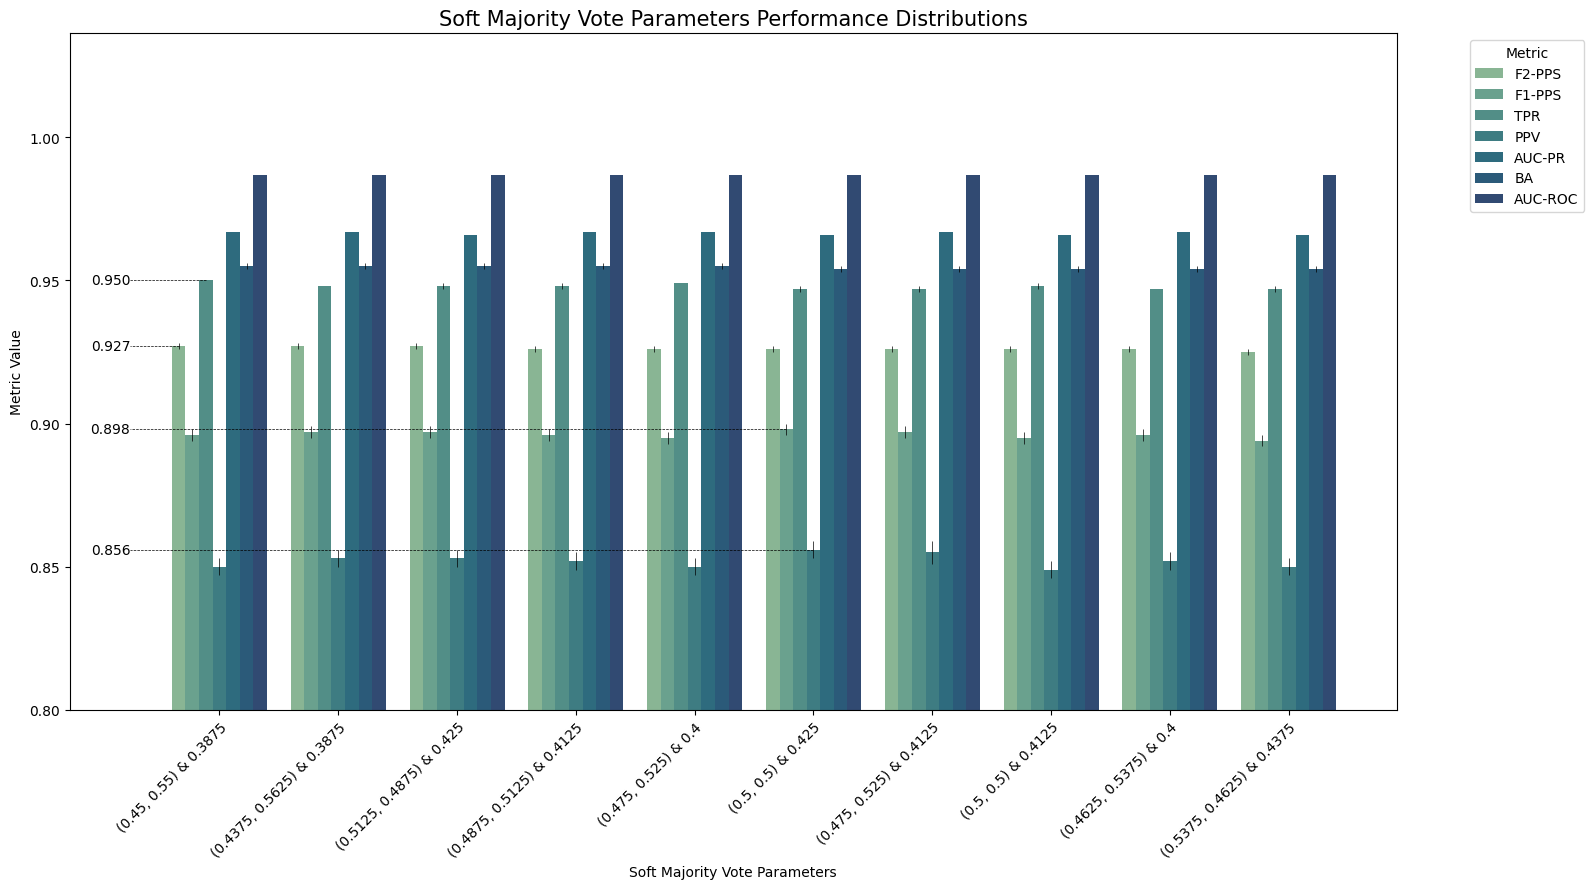

In [ ]:
frame = results[['Soft Majority Vote Parameters'] + order].copy()

plot(frame, 'Soft Majority Vote Parameters', output, order)

* Select the **Soft Majority Vote Model Parameters** with the *highest performance at the lower bound of the confidence interval*

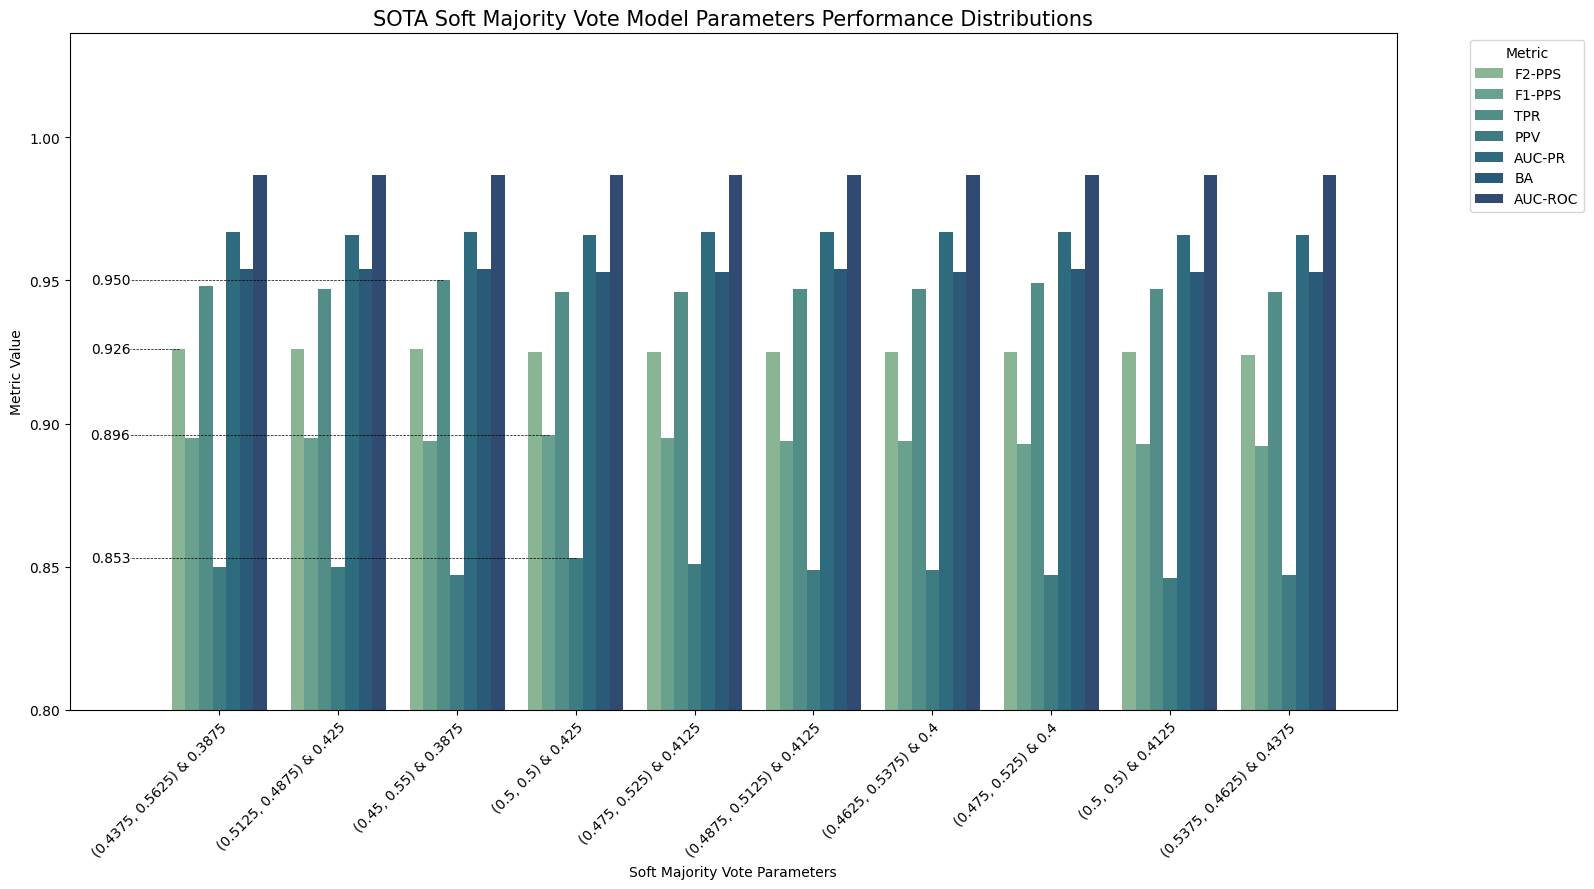

In [ ]:
base = select(
    dir = os.path.join(output, f'ranks.csv'),
    title = "SOTA Soft Majority Vote Model Parameters",
    column = 'Soft Majority Vote Parameters',
    output = output,
    main = ['Soft Majority Vote Parameters'],
    order = order,
    model = None
)